# Real-Time Face Mask Detection

### Import all the libraries and modules required.

In [1]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint

from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import cv2

### Build the neural network

In [2]:
model = Sequential([
    Conv2D(256, (3,3), activation='tanh', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.1),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.1),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 36, 36, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        7

### Image Data Generation/Augmentation

In [4]:
# C:\Users\prati\Desktop\python project face mask tool\dataset\face-mask\Train
TRAINING_DIR = r"C:\Users\prati\Desktop\python project face mask tool\dataset\face-mask\Train"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=32, 
                                                    target_size=(150, 150))
VALIDATION_DIR = r"C:\Users\prati\Desktop\python project face mask tool\dataset\face-mask\Test"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                         batch_size=32, 
                                                         target_size=(150, 150))

Found 4301 images belonging to 2 classes.
Found 1590 images belonging to 2 classes.


Found 4301 files belonging to 2 classes.


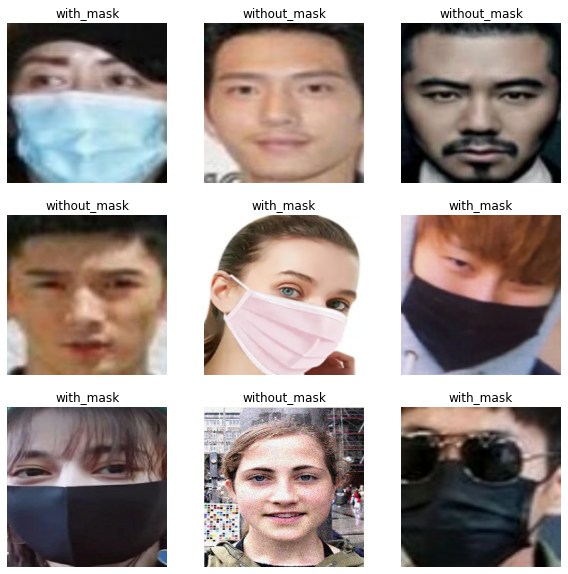

In [7]:
import matplotlib.pyplot as plt
train_ds = tf.keras.utils.image_dataset_from_directory(TRAINING_DIR,image_size=(224, 224),batch_size=32)
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Train the model: 

In [5]:
history = model.fit(train_generator,epochs=32,validation_data=validation_generator)

Epoch 1/32
 37/135 [=======>......................] - ETA: 59s - loss: 0.6329 - acc: 0.6554 

D:\ProgramData\Anaconda3\envs\tflow-gpu\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


135/135 [==============================] - 106s 685ms/step - loss: 0.4818 - acc: 0.7817 - val_loss: 0.2298 - val_acc: 0.9308
Epoch 2/32
135/135 [==============================] - 92s 678ms/step - loss: 0.3641 - acc: 0.8554 - val_loss: 0.1972 - val_acc: 0.9434
Epoch 3/32
135/135 [==============================] - 92s 680ms/step - loss: 0.3546 - acc: 0.8551 - val_loss: 0.1896 - val_acc: 0.9484
Epoch 4/32
135/135 [==============================] - 91s 674ms/step - loss: 0.3334 - acc: 0.8696 - val_loss: 0.1691 - val_acc: 0.9447
Epoch 5/32
135/135 [==============================] - 91s 674ms/step - loss: 0.3046 - acc: 0.8796 - val_loss: 0.2310 - val_acc: 0.9289
Epoch 6/32
135/135 [==============================] - 92s 680ms/step - loss: 0.3046 - acc: 0.8833 - val_loss: 0.1464 - val_acc: 0.9516
Epoch 7/32
135/135 [==============================] - 91s 674ms/step - loss: 0.3018 - acc: 0.8828 - val_loss: 0.1473 - val_acc: 0.9535
Epoch 8/32
135/135 [==============================] - 91s 672ms/s

### evaluating the model

Text(0.5, 1.0, 'Training and validation loss')

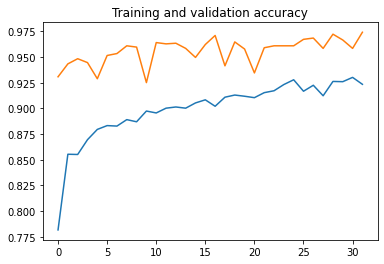

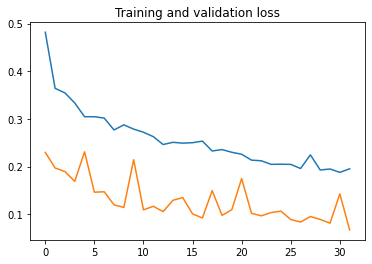

In [6]:
from matplotlib import pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) 

plt.plot(epochs,acc)

plt.plot(epochs,val_acc)
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot(epochs,loss)
plt.plot(epochs,val_loss)
plt.title('Training and validation loss'   )

### exporting the model

In [7]:
model.save('mask_detector_with_cudnn_3_layers_32+epoch.model')

INFO:tensorflow:Assets written to: mask_detector_with_cudnn_3_layers_32+epoch.model\assets


INFO:tensorflow:Assets written to: mask_detector_with_cudnn_3_layers_32+epoch.model\assets


### Test the results of face mask detector model using OpenCV

In [2]:
import cv2
import numpy as np
from keras.models import load_model
model=load_model("./mask_detector_with_cudnn_3_layers_32+epoch.model")

results={0:'without mask',1:'mask'}
GR_dict={0:(0,0,255),1:(0,255,0)}

rect_size = 4
cap = cv2.VideoCapture(0) 


#haarcascade = cv2.CascadeClassifier('/home/user_name/.local/lib/python3.6/site-packages/cv2/data/haarcascade_frontalface_default.xml')
haarcascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
while True:
    (rval, im) = cap.read()
    im=cv2.flip(im,1,1) 

    
    rerect_size = cv2.resize(im, (im.shape[1] // rect_size, im.shape[0] // rect_size))
    faces = haarcascade.detectMultiScale(rerect_size)
    for f in faces:
        (x, y, w, h) = [v * rect_size for v in f] 
        
        face_img = im[y:y+h, x:x+w]
        rerect_sized=cv2.resize(face_img,(150,150))
        normalized=rerect_sized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)

        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),GR_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),GR_dict[label],-1)
        cv2.putText(im, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

    cv2.imshow('LIVE', im)
    key = cv2.waitKey(10)
    
    if key == 27: 
        break

cap.release()

cv2.destroyAllWindows()

1/1 [==============================] - 0s 52ms/step
